In [1]:
#导入常用模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime,timedelta

In [2]:
#数据建立时间轴，取部分特征
df = pd.read_csv('stock1.csv')
df['date'] = pd.to_datetime(df[df.columns[0]])
df.set_index('date',inplace =True)
select_feature = ['IBM','XOM','SPX']
df_p1 = df[select_feature]

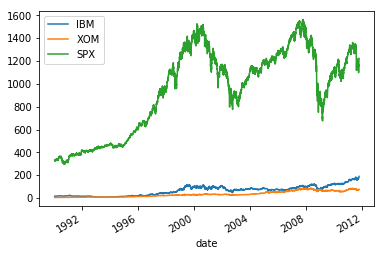

In [3]:
df_p1.plot()
plt.show()

###### 可以看到SPX很不平稳， IBM和XOM相对平稳。

<Figure size 720x720 with 0 Axes>

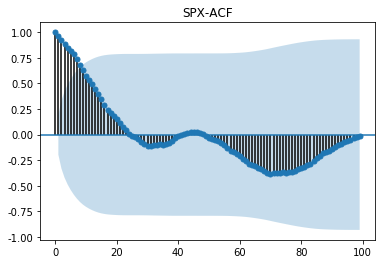

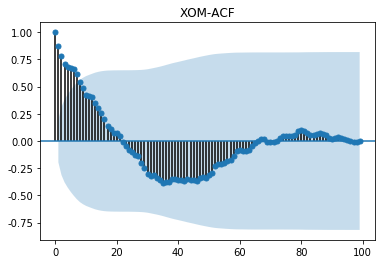

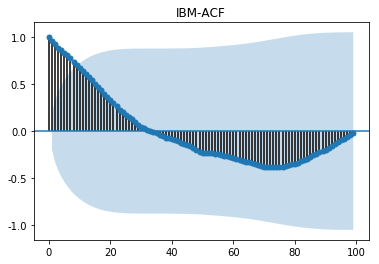

In [6]:
#每个特征前100个样本自相关图
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(10,10))
plot_acf(df_p1.iloc[:100,df_p1.columns.get_loc('SPX')])
plt.title('SPX-ACF')
plot_acf(df_p1.iloc[:100,df_p1.columns.get_loc('XOM')])
plt.title('XOM-ACF')
plot_acf(df_p1.iloc[:100,df_p1.columns.get_loc('IBM')])
plt.title('IBM-ACF')
plt.show()

###### 看自相关图都不平稳，做一下平稳性检验吧。

In [7]:
#平稳性检验 原假设为不平稳
print('SPX P-Value:',ADF(df_p1['SPX'])[1])
print('XOM P-Value:',ADF(df_p1['XOM'])[1])
print('IBM P-Value:',ADF(df_p1['IBM'])[1])

SPX P-Value: 0.5037180736830403
XOM P-Value: 0.9368986668793953
IBM P-Value: 0.9843355705636424


###### 由P值可以看出3个序列都不平稳

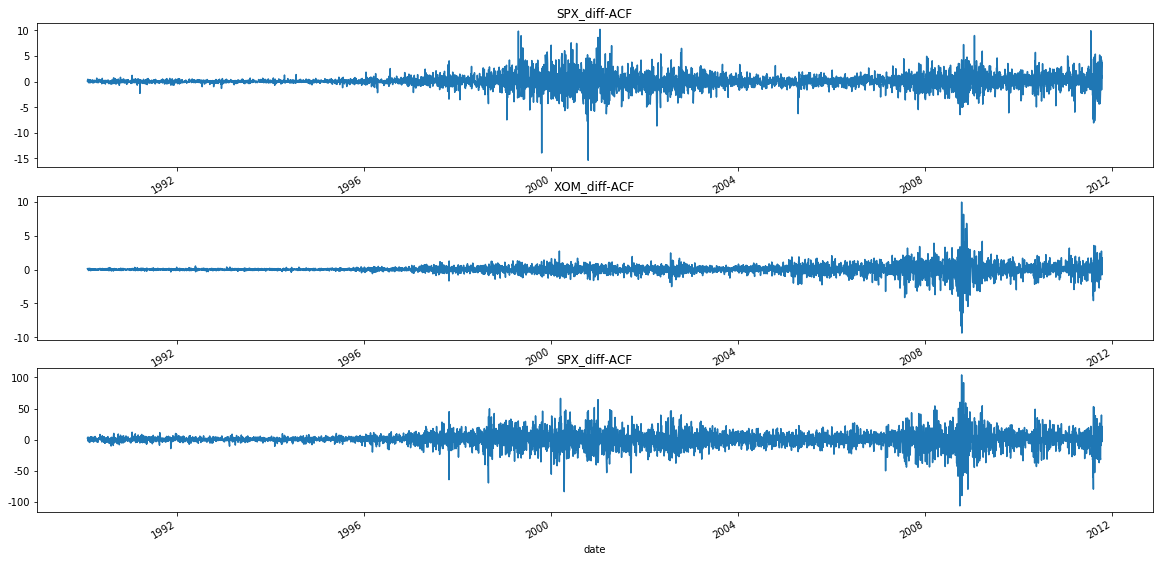

In [8]:
#一阶差分后  画出差分图
df_p1_diff = df_p1.diff().dropna()
df_p1_diff.columns = df_p1.columns + '_diff'

plt.figure(figsize=(20,10))
plt.subplot(311)
df_p1_diff['IBM_diff'].plot()
plt.title('SPX_diff-ACF')
plt.subplot(312)
df_p1_diff['XOM_diff'].plot()
plt.title('XOM_diff-ACF')
plt.subplot(313)
df_p1_diff['SPX_diff'].plot()
plt.title('SPX_diff-ACF')
plt.show()

###### 看起来平稳了许多。

<Figure size 720x1440 with 0 Axes>

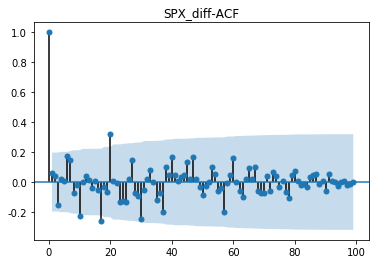

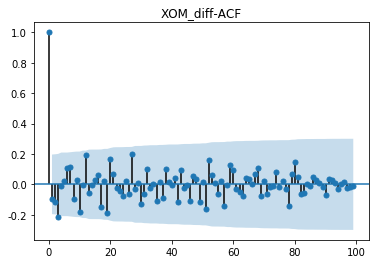

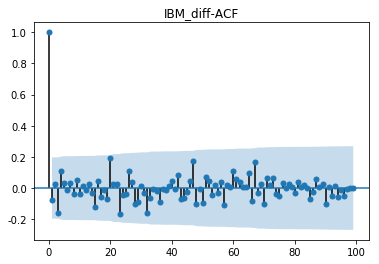

In [9]:
#差分后作自相关图
plt.figure(figsize=(10,20))
plot_acf(df_p1_diff.iloc[:100,df_p1_diff.columns.get_loc('SPX_diff')])
plt.title('SPX_diff-ACF')
plot_acf(df_p1_diff.iloc[:100,df_p1_diff.columns.get_loc('XOM_diff')])
plt.title('XOM_diff-ACF')
plot_acf(df_p1_diff.iloc[:100,df_p1_diff.columns.get_loc('IBM_diff')])
plt.title('IBM_diff-ACF')
plt.show()

In [10]:
#平稳性检验 原假设为不平稳
print('SPX_diff P-Value:',ADF(df_p1_diff['SPX_diff'])[1])
print('XOM_diff P-Value:',ADF(df_p1_diff['XOM_diff'])[1])
print('IBM_diff P-Value:',ADF(df_p1_diff['IBM_diff'])[1])

SPX_diff P-Value: 8.716937990838092e-25
XOM_diff P-Value: 6.853447440462515e-27
IBM_diff P-Value: 1.6058948947149212e-28


###### 均远小于0.05，一阶差分后的序列平稳

D:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<Figure size 720x1440 with 0 Axes>

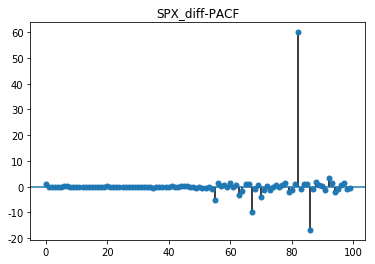

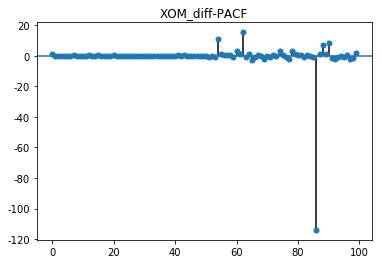

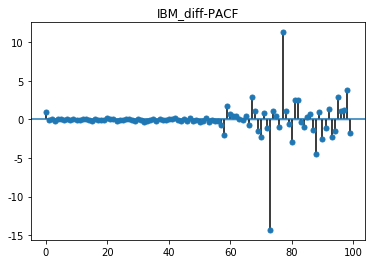

In [11]:
# 差分后作偏自相关图
plt.figure(figsize=(10,20))
plot_pacf(df_p1_diff.iloc[:100,df_p1_diff.columns.get_loc('SPX_diff')])
plt.title('SPX_diff-PACF')
plot_pacf(df_p1_diff.iloc[:100,df_p1_diff.columns.get_loc('XOM_diff')])
plt.title('XOM_diff-PACF')
plot_pacf(df_p1_diff.iloc[:100,df_p1_diff.columns.get_loc('IBM_diff')])
plt.title('IBM_diff-PACF')
plt.show()

In [12]:
#屏蔽warning
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [13]:
#白噪声检验  原假设：序列是白噪声
print("APPL_diff白噪声检验(P-value):",acorr_ljungbox(df_p1_diff['SPX_diff'], lags=1)[1] )
print("MSFT_diff白噪声检验(P-value):",acorr_ljungbox(df_p1_diff['XOM_diff'], lags=1)[1] )
print("XOM_diff白噪声检验(P-value):",acorr_ljungbox(df_p1_diff['IBM_diff'], lags=1)[1] )

APPL_diff白噪声检验(P-value): [3.81844612e-07]
MSFT_diff白噪声检验(P-value): [6.61134686e-27]
XOM_diff白噪声检验(P-value): [0.00584858]


###### P值都小于0.05 可见差分后的序列都不是白噪声。

# 模型定阶

In [14]:
#XOM建模
pmax = 4
qmax = 4

bic_matrix = []
for p in range(pmax + 1):
    tmp = []
    for q in range(qmax + 1):
        try:
            tmp.append(ARIMA(df_p1_diff['XOM_diff'],(p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

bic_matrix = pd.DataFrame(bic_matrix)
p,q = bic_matrix.stack().idxmin()
print('BIC最小的p值和q值为:{} , {}'.format(p,q))

BIC最小的p值和q值为:3 , 3


In [15]:
#用建立的模型进行预测
model = ARIMA(df_p1_diff['XOM_diff'],(3,1,3)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.XOM_diff   No. Observations:                 5470
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -6027.165
Method:                       css-mle   S.D. of innovations              0.728
Date:                Sun, 10 Feb 2019   AIC                          12070.330
Time:                        11:37:54   BIC                          12123.186
Sample:                             1   HQIC                         12088.771
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.692e-06   5.32e-06      0.506      0.613   -7.74e-06    1.31e-05
ar.L1.D.XOM_diff    -1.5383      0.071    -21.527      0.000      -1.678      -1.398
ar.L2.D.XOM_diff    -0.7844      0.075    -10.417      0.000      -0.932      -0.637
ar.L3.D.XOM_diff    -0.2019      0.014    -14.556      0.000      -0.229      -0.175
ma.L1.D.XOM_diff     0.3879      0.073      5.330      0.000       0.245       0.531
ma.L2.D.XOM_diff    -0.9330      0.013    -72.320      0.000      -0.958      -0.908
ma.L3.D.XOM_diff    -0.4543      0.070     -6.493      0.000      -0.591      -0.317
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0785           -0.0000j            1.0785           -0.5000
AR.2           -1.4029           -1.6197j            2.1428           -0.3636
AR.3           -1.4029           +1.6197j            2.1428            0.3636
MA.1            1.0002           +0.0000j            1.0002            0.0000
MA.2           -1.1651           +0.0000j            1.1651            0.5000
MA.3           -1.8890           +0.0000j            1.8890            0.5000
-----------------------------------------------------------------------------
"""

In [16]:
#用建立好的ARIMA预测XOM未来5天的股价
diff = pd.Series(list(model.forecast(5)[0]),index=pd.date_range(start =   df_p1.index[-1]+timedelta(days = 1),periods = 5,freq = 'd'))
forecast = pd.Series([df_p1.loc[df_p1.index[-1],'XOM']],index = [df_p1.index[-1]]).append(diff).cumsum()
forecast

2011-10-14    78.110000
2011-10-15    77.939436
2011-10-16    77.839898
2011-10-17    77.846974
2011-10-18    78.020170
2011-10-19    77.839857
dtype: float64

In [18]:
df_p1.tail(5)

,IBM,XOM,SPX
date,,,
2011-10-10,186.62,76.28,1194.89
2011-10-11,185.00,76.27,1195.54
2011-10-12,186.12,77.16,1207.25
2011-10-13,186.82,76.37,1203.66
2011-10-14,190.53,78.11,1224.58
